In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import msgpack as mp
import msgpack_numpy as mpn
sys.path.append(os.path.join(os.getcwd(), ".."))
from support.generate_ar_data import *
from support.pd_support import *
from support.calculations_support import *
from support.mecanum_calculations import *
from support.ar_calculations import *
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm

In [2]:
_parent_folder = "single_cam_jan_5_2023_3cm"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\recording_programs\\test_data\\single_cam_jan_5_2023_3cm'

In [3]:
""" read excel sheet"""
folder_df = pd.read_excel(os.path.join(_base_pth, "00_analysis", "calibration_files.xlsx"))
_analysis_pth = os.path.join(_base_pth, "00_analysis")
folder_df

,folder_name,calibration_folder,flip
0,sk20_15_forward_fast,calibration_15fps_00,False
1,sk20_15_forward_fast_2,calibration_15fps_00,False
2,sk20_15_forward_medium,calibration_15fps_00,False
3,sk20_15_forward_medium_2,calibration_15fps_00,False
4,sk20_15_forward_slow,calibration_15fps_00,False
...,...,...,...
91,sk20_60_sideways_fast_2,calibration_60fps_00,False
92,sk20_60_sideways_medium,calibration_60fps_00,False
93,sk20_60_sideways_medium_2,calibration_60fps_00,False
94,sk20_60_sideways_slow,calibration_60fps_00,False


In [4]:

def transform_coordinates_1(df, rotmat, org):
    df1 = df.copy( deep=True)
    for i in range(len(df)):
        val = df[["x", "y", "z"]].loc[i].values
        val = np.reshape(val, (3,1))
        _temp = val - org
        translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)
        _val = rotmat.T @ _temp
        _val = _val - translation_correction
        
        df1["x"].replace({df1["x"].loc[i]: _val[0]}, inplace=True)
        df1["y"].replace({df1["y"].loc[i]: _val[1]}, inplace=True)
        df1["z"].replace({df1["z"].loc[i]: _val[2]}, inplace=True)

    return df1

In [27]:
mean_err_df = pd.DataFrame(columns=["folder_name","date_created" ,"frame_id","err_x", "err_y", "err_z", "max_err_x", "max_err_y", "max_err_z", "std_err_x", "std_err_y", "std_err_z"])

In [28]:
for i in tqdm(range(len(folder_df))):
    folder_no = i
    #open the calibration files
    _pth = folder_df.folder_name[folder_no]
    _pth = os.path.join(_base_pth, _pth)

    #read the calibration file
    _webcam_calib_folder = folder_df.calibration_folder[folder_no]
    _webcam_calib_folder = os.path.join(_base_pth, _webcam_calib_folder)
    _webcam_calib_pth = os.path.join(_base_pth, _webcam_calib_folder, "webcam_calibration.msgpack")


    with open(_webcam_calib_pth, "rb") as f:
        webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
        _temp = next(webcam_calib)
        _webcam_cam_mat = _temp[0]
        _webcam_dist = _temp[1]
    _webcam_video_pth = os.path.join(_pth, "webcam_color.msgpack")
    _webcam_timestamp_pth = os.path.join(_pth, "webcam_timestamp.msgpack")


    with open(os.path.join(_webcam_calib_folder, "webcam_rotmat.msgpack"), "rb") as f:
        webcam_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
        _webcam_rot = next(webcam_rotmat)
        _webcam_org = next(webcam_rotmat)

    _flip = folder_df.flip[i]
    # if _flip == "TRUE":
    #     _flip = True
    # else:
    #     _flip = False
    _date_created = os.path.getctime(_webcam_video_pth)
    # print(_date_created)
    
    _w_df = get_ar_pose_data(_webcam_video_pth, _webcam_cam_mat, _webcam_dist, is_color=False, single_file=True, flip_frame=_flip)

    _w_df = add_time_from_file(_w_df, _webcam_timestamp_pth)
    

    w_df = _w_df.copy(deep=True) # comment this if your doing processing

    # w_df = transform_coordinates_1(_w_df, _webcam_rot, _webcam_org)

    mc_df_pth = os.path.join(_base_pth, folder_df.folder_name[folder_no].split("_")[0], folder_df.folder_name[folder_no]+ ".csv")
    _m_df, st_time = read_df_csv(mc_df_pth)
    _m_df = add_datetime_col(_m_df, st_time, _name="seconds")


    _m_df["x"] = _m_df["lb_x"] + _m_df["rb_x"] + _m_df["lt_x"] + _m_df["rt_x"]
    _m_df["y"] = _m_df["lb_y"] + _m_df["rb_y"] + _m_df["lt_y"] + _m_df["rt_y"]
    _m_df["z"] = _m_df["lb_z"] + _m_df["rb_z"] + _m_df["lt_z"] + _m_df["rt_z"]

    _m_df["x"] = _m_df["x"] / 4
    _m_df["y"] = _m_df["y"] / 4
    _m_df["z"] = _m_df["z"] / 4

    

    w_df, _m_df = trunkate_dfs(w_df, _m_df)

    w_df = interpolate_target_df(w_df, _m_df)

    # write to csv file
    _m_df.to_csv(os.path.join(_analysis_pth, "coordinates_mc", folder_df.folder_name[folder_no] + ".csv"), index=False)
    # write to csv file
    w_df.to_csv(os.path.join(_analysis_pth, "coordinates_webcam_wot",folder_df.folder_name[folder_no] + ".csv"), index=False)

    error_df = pd.DataFrame()
    error_df["time"] = _m_df["time"]
    error_df["x"] = _m_df["x"] - w_df["x"]
    error_df["y"] = _m_df["y"] - w_df["y"]
    error_df["z"] = _m_df["z"] - w_df["z"]
    error_df["frame_id"] = w_df["frame_id"]

    mean_err_df = mean_err_df.append({"folder_name": folder_df.folder_name[folder_no],"date_created": _date_created, "frame_id":  error_df["frame_id"][0],
                                    "err_x": error_df["x"].mean(), "err_y": error_df["y"].mean(), "err_z": error_df["z"].mean(), 
                                    "max_err_x": error_df["x"].max(), "max_err_y": error_df["y"].max(), "max_err_z": error_df["z"].max(), 
                                    "std_err_x": error_df["x"].std(), "std_err_y": error_df["y"].std(), "std_err_z": error_df["z"].std()}, ignore_index=True)
    


100%|██████████| 89/89 [17:52<00:00, 12.05s/it]


In [20]:
mean_err_df

,folder_name,date_created,frame_id,err_x,err_y,err_z,max_err_x,max_err_y,max_err_z,std_err_x,std_err_y,std_err_z
0,sk16_15_forward_fast,1.668605e+09,5.0,0.000526,-0.012339,0.015757,0.070884,0.077505,0.545924,0.007406,0.005102,0.039528
1,sk16_15_forward_fast_2,1.668605e+09,5.0,-0.000540,-0.012633,0.013277,0.010289,-0.007207,0.074525,0.006621,0.001860,0.030960
2,sk16_15_forward_medium,1.668604e+09,5.0,-0.000363,-0.012625,0.012512,0.009518,-0.001361,0.086528,0.006005,0.002159,0.020672
3,sk16_15_forward_medium_2,1.668604e+09,5.0,-0.000078,-0.012516,0.013455,0.015922,-0.006627,0.073867,0.006401,0.002365,0.020556
4,sk16_15_forward_slow,1.668604e+09,5.0,-0.001282,-0.012496,0.015094,0.009755,-0.000434,0.067342,0.006012,0.002621,0.019108
...,...,...,...,...,...,...,...,...,...,...,...,...
96,sk16_60_sideways_fast_2,1.668510e+09,5.0,0.026243,0.006780,-1.359076,0.079363,0.013109,-1.287017,0.026923,0.002842,0.026919
97,sk16_60_sideways_medium,1.668509e+09,5.0,0.023141,0.009633,-1.471548,0.072260,0.018392,-1.344241,0.023303,0.003567,0.054175
98,sk16_60_sideways_medium_2,1.668509e+09,5.0,0.025638,0.006952,-1.384426,0.077258,0.013555,-1.283281,0.022794,0.002892,0.038062
99,sk16_60_sideways_slow,1.668509e+09,5.0,0.025047,0.007767,-1.408051,0.091905,0.014301,-1.324037,0.012939,0.003593,0.068183


In [21]:
_mean_df_pth = os.path.join(_analysis_pth, "mean_error_df_wdate_25-11-22_01.csv")
mean_err_df.to_csv(_mean_df_pth, index=False)
mean_err_df

,folder_name,date_created,frame_id,err_x,err_y,err_z,max_err_x,max_err_y,max_err_z,std_err_x,std_err_y,std_err_z
0,sk16_15_forward_fast,1.668605e+09,5.0,0.000526,-0.012339,0.015757,0.070884,0.077505,0.545924,0.007406,0.005102,0.039528
1,sk16_15_forward_fast_2,1.668605e+09,5.0,-0.000540,-0.012633,0.013277,0.010289,-0.007207,0.074525,0.006621,0.001860,0.030960
2,sk16_15_forward_medium,1.668604e+09,5.0,-0.000363,-0.012625,0.012512,0.009518,-0.001361,0.086528,0.006005,0.002159,0.020672
3,sk16_15_forward_medium_2,1.668604e+09,5.0,-0.000078,-0.012516,0.013455,0.015922,-0.006627,0.073867,0.006401,0.002365,0.020556
4,sk16_15_forward_slow,1.668604e+09,5.0,-0.001282,-0.012496,0.015094,0.009755,-0.000434,0.067342,0.006012,0.002621,0.019108
...,...,...,...,...,...,...,...,...,...,...,...,...
96,sk16_60_sideways_fast_2,1.668510e+09,5.0,0.026243,0.006780,-1.359076,0.079363,0.013109,-1.287017,0.026923,0.002842,0.026919
97,sk16_60_sideways_medium,1.668509e+09,5.0,0.023141,0.009633,-1.471548,0.072260,0.018392,-1.344241,0.023303,0.003567,0.054175
98,sk16_60_sideways_medium_2,1.668509e+09,5.0,0.025638,0.006952,-1.384426,0.077258,0.013555,-1.283281,0.022794,0.002892,0.038062
99,sk16_60_sideways_slow,1.668509e+09,5.0,0.025047,0.007767,-1.408051,0.091905,0.014301,-1.324037,0.012939,0.003593,0.068183


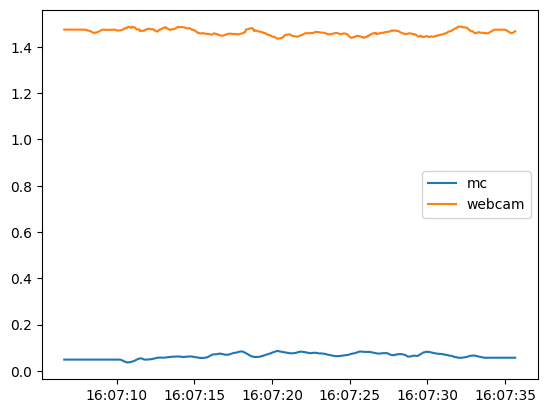

In [22]:
plt.plot(_m_df["time"], _m_df["z"], label="mc")
# plt.plot(_w_df["time"], _w_df["z"].rolling(13).median()*-1  +1.5, label="webcam")
plt.plot(w_df["time"], savgol_filter(w_df["z"].values, 51, 1, mode='nearest') + 0.045, label="webcam")
plt.legend()

In [ ]:
# find error between x , y, z and yaw, pitch, roll
error_df = pd.DataFrame()
error_df["time"] = _m_df["time"]
error_df["x"] = _m_df["x"] - w_df["x"]
error_df["y"] = _m_df["y"] - w_df["y"]
error_df["z"] = _m_df["z"] - w_df["z"]

In [ ]:
print(error_df.x.mean())
print(error_df.y.mean())
print(error_df.z.mean())